In [1]:
# Photometry using VYSOS data 

import numpy as np
import matplotlib.pyplot as plt 

import photutils
from photutils import aperture_photometry
from photutils import SkyCircularAperture

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.io import fits
from astropy.wcs import WCS

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1200

import glob
import scipy
import scipy.constants
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline


### Kyle Barbaery's SEP 
### astropy.io 
### David's nuphot.py

### CMOS camera J. Walawender friend 
## 60 megapix camera 
## data good 
## want 2 see data from blue side of dichroic 

### could be useful 
# for x,y in xycoords: 
#     print(x,y)
#     print(x)


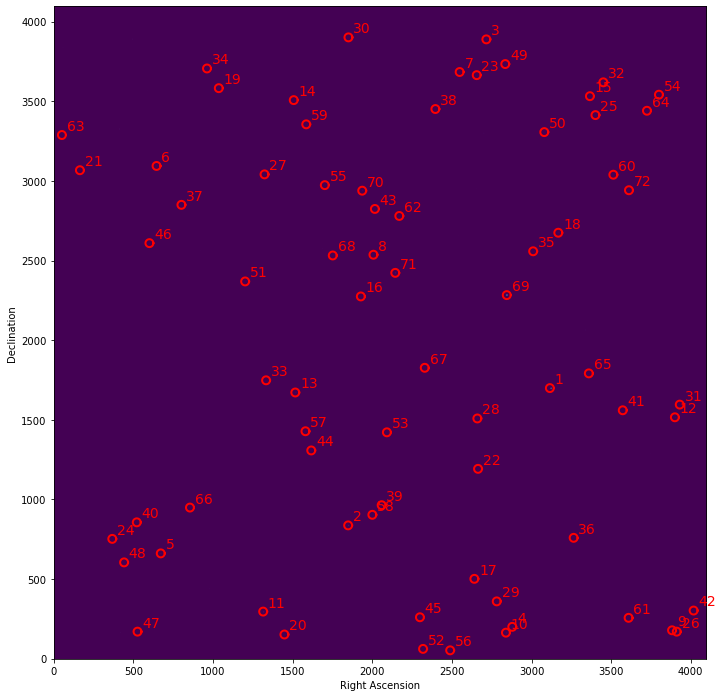

In [2]:
# loading outputs from astrometry.net.. 

## WCS header
path = '/usr/local/Cellar/astrometry-net/0.82/data/'
wcs = WCS(header = path+'aug08-0003V.wcs')
# print('wcs header',wcs)

## source positions, RA, Dec  
hdulradec = fits.open(path+'aug08-0003V.rdls')
radeccoords = hdulradec[1].data
racoord = [x for x,y in radeccoords]
deccoord = [y for x,y in radeccoords]

## source positions, pixels 
hdulxy = fits.open(path+'aug08-0003V-indx.xyls')
xycoords = hdulxy[1].data
xcoord = [x for x,y in xycoords]
ycoord = [y for x,y in xycoords]


########## plottnig 
theta = np.arange(21)/10*np.pi 
ct = np.cos(theta) 
st = np.sin(theta) 
r = 25

fig = plt.figure(figsize=(12,12))
image_data = fits.getdata(path+'aug08-0003V.fit')

ax = plt.subplot()
ax.imshow(image_data, cmap='viridis', origin='lower')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

for i in range(len(xcoord)):
    ax.plot(xcoord[i]+r*ct, ycoord[i]+r*st, color='red', lw=2)
    ax.text(xcoord[i]+30, ycoord[i]+30, str(i+1), color='red', fontsize=14)

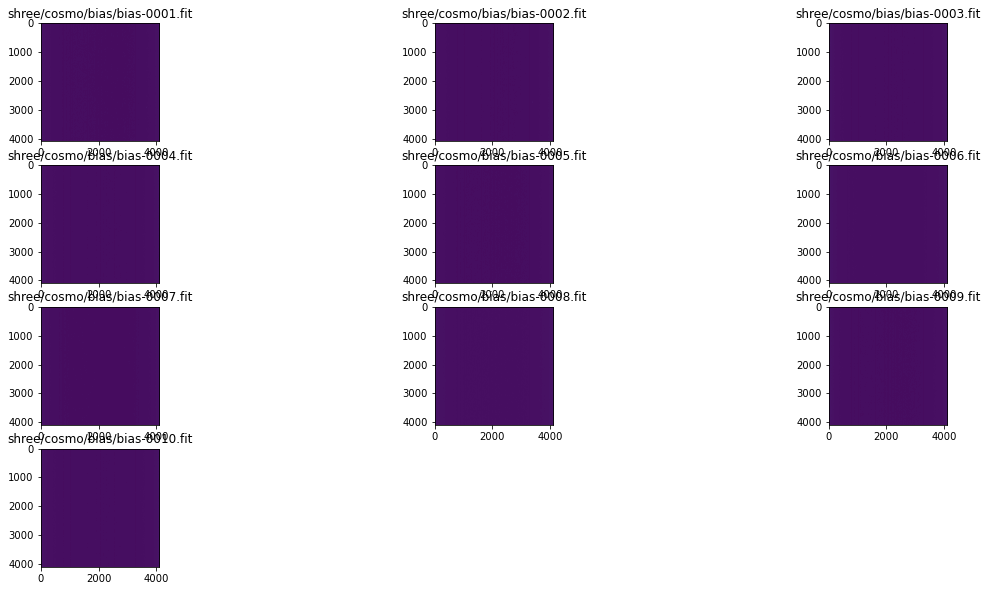

In [3]:
# load bias frames
biasfilenames = []
for i in range(1,10):
    biasfilename_i = '/Users/vanshree/cosmo/bias/bias-000'+str(i)+'.fit'
    biasfilenames = np.append(biasfilenames,biasfilename_i)
biasfilenames = np.append(biasfilenames,'/Users/vanshree/cosmo/bias/bias-0010.fit')


fig = plt.figure(figsize=(20,10))
plt.set_cmap('viridis')

biasarr = []

for n in range(len(biasfilenames)):
    file = str(biasfilenames[n])
    hdubias = fits.open(file)
    imbias = hdubias[0].data
    hdbias = hdubias[0].header
        
    f1 = fig.add_subplot(4,3,n+1)
    vmedian = np.nanmedian(imbias)
    
    f1.imshow(np.arcsinh(imbias))
    plt.title(biasfilenames[n][10::])

    biasarr.append(imbias)

    


Shape of stacked bias-frames =  (10, 4096, 4096)
Shape of the median image generated =  (4096, 4096)
Mean of combined bias frame is 1133.6982711553574 counts 


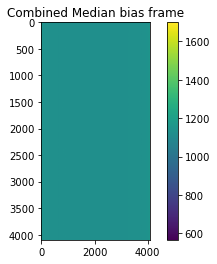

In [4]:
# median bias frame
plt.set_cmap('viridis')

print("Shape of stacked bias-frames = ",np.shape(biasarr)) #should be 5 x 80 x 512
biasmed = np.median(biasarr, axis=0)
print("Shape of the median image generated = ",np.shape(biasmed))
vmedian = np.nanmedian(biasmed)

plt.title("Combined Median bias frame")
plt.imshow(biasmed,vmin=0.5*np.abs(vmedian), vmax=1.5*np.abs(vmedian), aspect=2)
plt.colorbar()
print("Mean of "+ "combined bias frame" + " is " + str(np.mean(biasmed)) + " counts ")

image mean 1144.0448556542397


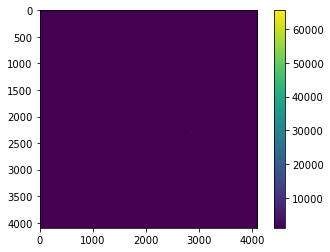

In [5]:
### show image 
imagedata = fits.getdata(path+'aug08-0003V.fit')
plt.imshow(imagedata)#, cmap='gray')
plt.colorbar()
print('image mean',np.mean(imagedata))

image mean 10.346584498882294


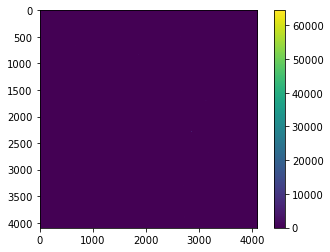

In [6]:
biassubtractedimage = imagedata - biasmed
plt.imshow(biassubtractedimage)#, cmap='gray')
plt.colorbar()
print('image mean',np.mean(biassubtractedimage))

In [19]:
 ## make apertures and do photometry 
from photutils import CircularAperture
from photutils import CircularAnnulus

xycoords = np.array(list(xycoords))

aperture = CircularAperture(xycoords,r=3)
annulus_aperture = CircularAnnulus(xycoords, r_in=6., r_out=8.)
apers = [aperture, annulus_aperture]

phot_table = aperture_photometry(biassubtractedimage,apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g' 
print(phot_table)

### subtract background 
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_sum = bkg_mean * aperture.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'

print('\n')
print(phot_table['residual_aperture_sum']) 


 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1  3115.016 1699.2802      391122.63       133150.8
  2 1848.2916 837.26679      168783.15      8892.7582
  3 2716.1224 3888.9703      53770.413      5358.2949
  4 2878.9525 200.28044      81848.032      8397.5512
  5 671.71587 661.36219      64062.282      5605.6016
  6 645.28358 3094.1765      42870.216      4462.8481
  7 2548.5087 3684.0227      28570.606      2707.7585
  8 2007.2246 2536.6572       11822.42      1550.5097
  9 3882.1145 178.47183      3793.2786      1002.6465
 10 2838.9843  163.5456      88934.349      5588.0444
...       ...       ...            ...            ...
 63 51.037703 3288.4269      6968.4331      1642.8443
 64 3724.5468 3440.7269      2488.0957      1295.1772
 65 3359.6342 1791.7012      3418.3752      1375.0901
 66 854.95824 949.14537      2894.7734      1097.2357
 67 2329.2804 1826.7816     

In [30]:
## convert to magnitudes
# instrumental magnitude 
hdul = fits.open(path+'aug08-0003V.fit')
hdr = hdul[0].header
exptime = hdul[0].header['EXPOSURE']
# print('exptime',exptime)

counts_array = np.array(phot_table['residual_aperture_sum'])
time_array = np.ones(len(counts_array))*exptime

mags_array = -2.5*np.log10(counts_array/time_array)
print('mags_array = ',mags_array)

mags_array =  [-10.16215586  -9.35697488  -8.09820915  -8.55330797  -8.29272805
  -7.85063432  -7.4134063   -6.44220053  -5.15833321  -8.65771822
  -9.22076789  -7.32707711  -8.08404308  -6.3876064   -5.40783746
  -3.13501043  -7.6235869   -7.18631899  -7.23188893  -7.51829766
  -7.33324278  -6.98210268  -5.50702436  -6.22229672  -3.42521288
  -5.89582553  -5.89506265  -7.54860586  -6.91302748  -6.55487107
  -2.04177805  -5.5192588   -4.92454336  -7.00901817  -7.12395257
  -5.89461851  -6.45537086  -6.35070414  -5.75762292  -5.84166135
  -2.06660654  -3.23009503  -4.95100688  -6.89815137  -6.65463728
  -6.32257884  -5.67205237  -5.16831882  -5.07091889  -5.40514005
  -1.78704946  -6.14940398  -5.20047518  -5.09448038  -2.51711599
  -2.6638505   -4.57351729  -2.80907011  -5.07102063   1.37349426
  -5.62330762  -2.7948455   -5.82947491  -4.59806056  -4.99141853
  -4.8201744   -4.82377182  -4.12415012 -10.29298518  -8.22094861
  -8.67291024  -6.14418078]


In [ ]:
# print(hdul)
# #### astrometry 
# # load for all files
# # filename = '/Users/vanshree/cosmo/astrometry/data/aug08-0003V.fit'
# # hdu = fits.open(filename)[0]
# # fig = plt.figure()
# # fig.add_subplot(111, projection=wcs)
# # plt.imshow(hdu.data, origin='lower', cmap=plt.cm.viridis)
# # plt.xlabel('RA')
# # plt.ylabel('Dec')